In [700]:
import itertools
import math
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

im1_path = r'Boaz stars 1.png'
im2_path = r'Boaz stars 2.png'

## Load the Images

In [701]:
def load_image(img_path):
    im = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
    im = im.astype(float)
    return im

In [702]:
im1 = load_image(im1_path)
im2 = load_image(im2_path)

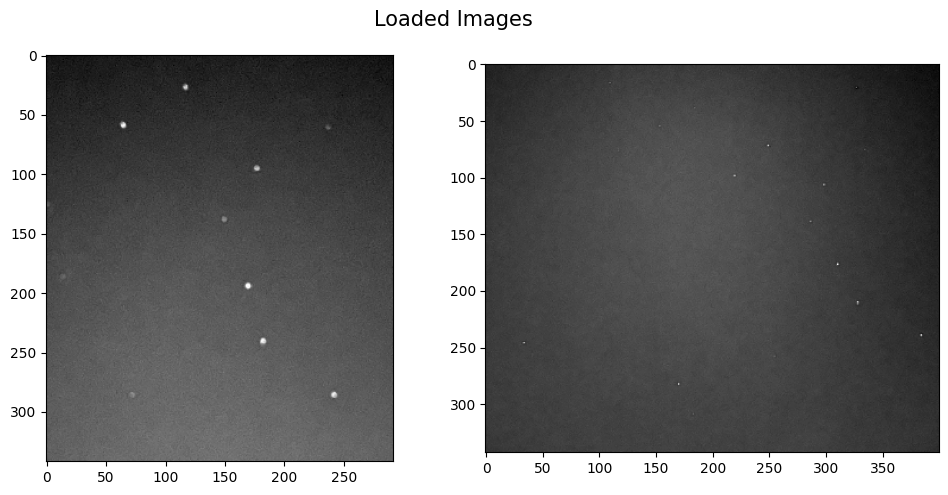

In [703]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
fig.suptitle("Loaded Images", size=15)
ax[0].imshow(im1, cmap='gray')
ax[1].imshow(im2, cmap='gray')
plt.tight_layout()
plt.show()

## Detect Stars in Each Image

In [704]:
def find_stars(img):
    mean, median, std = sigma_clipped_stats(img, sigma=3.0)
    daofind = DAOStarFinder(fwhm=3.0, threshold=1. * std)
    table = daofind(img - median)
    for col in table.colnames:
        if col not in ('id', 'npix'):
            table[col].info.format = '%.2f'  # for consistent table output
    return table

In [705]:
def print_data(stars):
    print(len(stars))
    stars.pprint()

In [706]:
im1_stars = find_stars(im1)
print_data(im1_stars)

15
 id xcentroid ycentroid sharpness roundness1 ... npix sky   peak  flux  mag 
--- --------- --------- --------- ---------- ... ---- ---- ------ ---- -----
  1    117.04     27.43      0.33      -0.00 ...   25 0.00  97.00 5.09 -1.77
  2     64.08     59.44      0.57      -0.01 ...   25 0.00 118.00 4.74 -1.69
  3     64.67     59.38      0.38      -0.26 ...   25 0.00 127.00 5.69 -1.89
  4    236.97     61.39      0.36      -0.02 ...   25 0.00  15.00 2.06 -0.79
  5    177.08     95.80      0.43      -0.20 ...   25 0.00  93.00 3.86 -1.47
  6      0.98    126.12      0.55      -0.62 ...   25 0.00  12.00 1.06 -0.07
  7    149.46    138.49      0.37      -0.07 ...   25 0.00  47.00 1.76 -0.61
  8    169.54    194.28      0.38      -0.14 ...   25 0.00 126.00 4.17 -1.55
  9    169.80    194.31      0.51       0.12 ...   25 0.00 129.00 4.11 -1.54
 10    169.55    193.96      0.55       0.17 ...   25 0.00 127.00 4.02 -1.51
 11    182.16    241.01      0.54       0.05 ...   25 0.00 126.00 4.48 -1

In [707]:
im2_stars = find_stars(im2)
print_data(im2_stars)

12
 id xcentroid ycentroid sharpness roundness1 ... npix sky   peak   flux  mag 
--- --------- --------- --------- ---------- ... ---- ---- ------ ----- -----
  1    361.85      6.09      0.66      -0.12 ...   25 0.00 -17.00  1.04 -0.04
  2    109.83     16.93      0.95      -0.57 ...   25 0.00  22.00  2.50 -1.00
  3    234.97     21.73      0.29      -0.41 ...   25 0.00   1.00  1.25 -0.24
  4    354.57     49.62      0.90      -0.58 ...   25 0.00  -7.00  1.30 -0.28
  5    162.99     76.39      0.72       0.55 ...   25 0.00  18.00  1.03 -0.03
  6    219.33     98.86      0.85      -0.30 ...   25 0.00  80.00  7.03 -2.12
  7    298.21    106.73      1.00      -0.21 ...   25 0.00  73.00  6.48 -2.03
  8    310.19    176.81      0.89      -0.26 ...   25 0.00 124.00 11.90 -2.69
  9    327.97    210.52      0.43       0.38 ...   25 0.00  57.00  9.43 -2.44
 10    383.82    239.64      0.77      -0.09 ...   25 0.00  84.00 10.21 -2.52
 11    387.89    247.20      0.64       0.03 ...   25 0.00  -

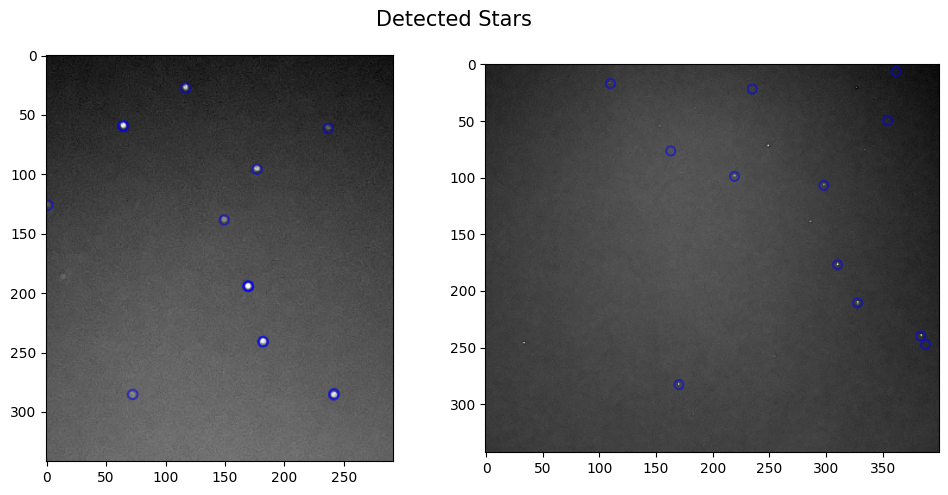

In [708]:
# plot detected stars in each image

im1_positions = np.transpose((im1_stars['xcentroid'], im1_stars['ycentroid']))
im1_apertures = CircularAperture(im1_positions, r=4.0)

im2_positions = np.transpose((im2_stars['xcentroid'], im2_stars['ycentroid']))
im2_apertures = CircularAperture(im2_positions, r=4.0)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
fig.suptitle("Detected Stars", size=15)
ax[0].imshow(im1, cmap='gray')
ax[1].imshow(im2, cmap='gray')
im1_apertures.plot(ax=ax[0], color='blue', lw=1.5, alpha=0.5)
im2_apertures.plot(ax=ax[1], color='blue', lw=1.5, alpha=0.5)
plt.tight_layout()
plt.show()

## Calculate Distances of Triangles in the Images

In [709]:
# all combinations of 3 points from each set
im1_combinations = list(itertools.combinations(range(len(im1_positions)), 3))
im2_combinations = list(itertools.combinations(range(len(im2_positions)), 3))

In [710]:
"""
Calculates Euclidean distance between two points.

Equivalent to:
x1, y1 = im1_positions[0]
x2, y2 = im1_positions[1]
math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
"""


def calc_dist(pos1, pos2):
    return math.dist(pos1, pos2)

In [711]:
def get_triangles(positions, combinations) -> list[np.ndarray]:
    # loop combinations to compute distances
    triangles = []
    for i, comb in enumerate(combinations):
        idx1, idx2, idx3 = comb
        pt1, pt2, pt3 = positions[idx1], positions[idx2], positions[idx3]
        distances = np.array([calc_dist(pt1, pt2), calc_dist(pt1, pt3), calc_dist(pt2, pt3)])
        min_side = distances.min()
        distances /= min_side  # normalize distances (THIS STEP IS IMPORTANT FOR TRIANGLE SIMILARITY!)
        distances.sort()  # sorts ascending (low to high), inplace (returns void)
        triangles.append(distances)
    return triangles

In [712]:
im1_triangles = get_triangles(im1_positions, im1_combinations)
im2_triangles = get_triangles(im2_positions, im2_combinations)

In [713]:
def get_error(tri1, tri2):
    return sum(np.abs(tri1 - tri2))

In [714]:
sums = []
thresh = 1.
curr_best_match, curr_min_err = None, math.inf

for i, im1_tri in enumerate(im1_triangles):
    for j, im2_tri in enumerate(im2_triangles):
        curr_err = get_error(im1_tri, im2_tri)  # the sides of each triangle were normalized and can be compared
        if curr_err < curr_min_err:
            curr_best_match = [i, j, curr_err]  # [idx-image-1, idx-image-2, error]
            curr_min_err = curr_err
    if curr_min_err < thresh and curr_best_match is not None:
        sums.append(curr_best_match)
    curr_best_match, curr_min_err = None, math.inf

In [715]:
sums = sorted(sums, key=lambda item: item[2])  # sort from lowest to highest error
sums[:5]

[[380, 191, 0.002399398651095952],
 [339, 84, 0.0072553821400893614],
 [374, 191, 0.007432505476825169],
 [338, 84, 0.00753662929905774],
 [388, 165, 0.008271815076456468]]

## Plot Result Matches

In [716]:
col_names = ['im1_comb_idx', 'im2_comb_idx', 'diff']
df = pd.DataFrame(data=sums, columns=col_names)
df[col_names[:2]] = df[col_names[:2]].astype(int)
print(f"Number of entries (before): {df.shape[0]}")
df.head()

Number of entries (before): 380


,im1_comb_idx,im2_comb_idx,diff
0,380,191,0.002399
1,339,84,0.007255
2,374,191,0.007433
3,338,84,0.007537
4,388,165,0.008272


In [717]:
# df.drop_duplicates(subset=col_names[0], keep='first', inplace=True)
df.drop_duplicates(subset=col_names[1], keep='first', inplace=True)
print(f"Number of entries (after): {df.shape[0]}")
df.head()

Number of entries (after): 94


,im1_comb_idx,im2_comb_idx,diff
0,380,191,0.002399
1,339,84,0.007255
4,388,165,0.008272
5,129,111,0.009042
6,161,67,0.009260


In [ ]:
reduced_sums = df.to_numpy().tolist()

n_rows = 1
fig, ax = plt.subplots(nrows=n_rows, ncols=2, figsize=(10, 5 * n_rows))

for row in range(n_rows):
    curr_tri = reduced_sums[row]
    im1_idx, im2_idx, _ = curr_tri
    im1_idx, im2_idx = round(im1_idx), round(im2_idx)
    im1_comb, im2_comb = im1_combinations[im1_idx], im2_combinations[im2_idx]
    im1_match_pts, im2_match_pts = [], []
    for i, j in zip(im1_comb, im2_comb):  # get point coordinates
        im1_match_pts.append(im1_positions[i])
        im2_match_pts.append(im2_positions[j])

    # get point apertures
    im1_aper = CircularAperture(im1_match_pts, r=4.0)
    im2_aper = CircularAperture(im2_match_pts, r=4.0)

    if n_rows == 1:
        # remove grid for simpler display
        ax[0].get_xaxis().set_visible(False)
        ax[0].get_yaxis().set_visible(False)
        ax[1].get_xaxis().set_visible(False)
        ax[1].get_yaxis().set_visible(False)

        ax[0].imshow(im1, cmap='gray')
        im1_aper.plot(ax=ax[0], color='blue', lw=1.5, alpha=0.5)

        ax[1].imshow(im2, cmap='gray')
        im2_aper.plot(ax=ax[1], color='blue', lw=1.5, alpha=0.5)

    else:
        # remove grid for simpler display
        ax[row, 0].get_xaxis().set_visible(False)
        ax[row, 0].get_yaxis().set_visible(False)
        ax[row, 1].get_xaxis().set_visible(False)
        ax[row, 1].get_yaxis().set_visible(False)

        ax[row, 0].imshow(im1, cmap='gray')
        im1_aper.plot(ax=ax[row, 0], color='blue', lw=1.5, alpha=0.5)

        ax[row, 1].imshow(im2, cmap='gray')
        im2_aper.plot(ax=ax[row, 1], color='blue', lw=1.5, alpha=0.5)

plt.tight_layout()
plt.show()

### Note:
How to reach indices:
positions (x,y) <- combinations (index of 3 positions) <- index of combination and triangles are corresponding

## Useful Sources:
1.